# MAC0460 / MAC5832 (2020)
<hr>

## EP3: Linear regression + gradient descent

### Topics explored:

- implementation and test of the *batch gradient descent* algorithm for solving the linear regression problem 
- understanding cost functions and the core idea of gradient descent
- comparison of both solutions (the analytic and the gradient descent based ones)

### The evaluation will consider 
- correctitude of the algorithms
- appropriateness of the answers
- Code
    - do not change the prototype of the function
    - efficiency (you should avoid unnecessary loops; use matrix/vector computation with NumPy wherever appropriate)
    - cleanliness (do not leave any commented code or useless variables)
- File format: Complete and submit this notebook. **PLEASE do no change the file name.**
<hr>

## Linear Regression

See EP2 to recall some terms and concepts.
See also the reference materials pointed in class log notes.


## Gradient descent

Gradient descent is a technique used to find the minimum of a function. Here we will use it to compute the minimum of the cost function $J:\mathbb{R}^{1+d} \rightarrow \mathbb{R}$:

\begin{equation}
J(\mathbf{w}) = \frac{1}{N}\sum_{i=1}^{N}\big(\hat{y}^{(i)} - y^{(i)}\big)^{2}
\end{equation}

where $\hat{y}^{(i)} = \mathbf{w}^T\mathbf{\tilde{x}}^{(i)}$, $\mathbf{\tilde{x}} = (1, x_1, \ldots, x_d)$.

We start at a random point $\mathbf{w}(0) \in \mathbb{R}^{1+d}$ at $t=0$, and at each iteration $t$ we compute the gradient of $J$ at $\mathbf{w}(t)$, and then update $\mathbf{w}(t)$ by a vector proportional to  $-\nabla_{\mathbf{w}}J(\mathbf{w})$ (the negative of the gradient).

- $\mathbf{w}(0) = \mathbf{w}$
- for $t = 0, 1, 2, \dots$ do
    * $\mathbf{w}(t+1) = \mathbf{w}(t) - \eta \nabla_{\mathbf{w}(t)}J(\mathbf{w}(t))$ 

The parameter $\eta \in \mathbb{R}_{\geq}$, known as **learning rate** controls the size of the updates. This parameter could be adaptivelly changed along the iterations, but we will keep it fixed (we will use the value defined at the beginning of the process).

### Gradient

The partial derivative of $J(\mathbf{w})$ with respect to each component $j$, $j=0,1,\ldots,d$, of $\mathbf{w}$ is given by

\begin{equation}
\frac{\partial J(\mathbf{w})}{\partial w_{j}} = \frac{2}{N}\sum_{i=1}^{N} (\hat{y}^{(i)} - y^{(i)})\, x^{(i)}_j
\end{equation}

Thus the gradient of $J(\mathbf{w})$ with respect to $\mathbf{w}$ is:

\begin{equation}
\nabla_{\mathbf{w}}J(\mathbf{w}) = \begin{bmatrix}\frac{\partial J(\mathbf{w})}{\partial w_{0}} \dots \frac{\partial J(\mathbf{w})}{\partial w_{d}} \end{bmatrix}
\end{equation}

## Imports and auxiliary functions


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from util.util import get_housing_prices_data, r_squared
from sklearn.metrics import mean_squared_error

    
def simple_step_plot(ylist, yname, title, figsize=(4, 4), labels=None):
    y0 = ylist[0]
    x = np.arange(1, len(y0) + 1, 1)
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for y in ylist:
        ax.plot(x, y)
    plt.xlabel('step')
    plt.ylabel(yname)
    plt.title(title,
              fontsize=14,
              fontweight='bold')
    plt.grid(True)
    if labels is not None:
        plt.legend(labels,
           loc='upper right')
    plt.show()

## The dataset 

Here we will use the *Boston Housing Prices*, available for download in `sklearn`, as shown below. See a description of the dataset for instance at https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html .
Due to visualization constraints, we use only one input variable (LSTAT) to predict the price of a house (in $1000s).

(you can also try using other variables or set of variables, or experiment with the same dataset of EP2)

In [12]:
data = load_boston()
df = pd.DataFrame(data.data, columns=data.feature_names)

X = df.LSTAT.values.reshape((-1,1))
y = data.target.reshape((-1,1))
print("X shape: ", X.shape)
print("y shape: ", y.shape)

plt.scatter(X[:,0], y, alpha=0.4)
plt.xlabel('LSTAT')
plt.ylabel('median value in $1000')

plt.show()

X shape:  (506, 1)
y shape:  (506, 1)


## Exercise 1

Write the code for the functions specified below, using matrix/vector computation with NumPy. Note that each function requires only a few lines of code:

- computation of the cost function value
- computation of the gradient
- optimization of the cost function: application of the gradient descent technique
- computation of the prediction

Note also that the dataset is input to some of the functions in its original shape $N\times d$ while it is input in the extended shape $N \times (1+d)$ for the others 

In [13]:
# computation of the cost function value
def compute_cost(Xe, y, w):
    """
    Calculates  mean square error cost.

    :param Xe: design matrix
    :type Xe: np.ndarray(shape=(N, 1+d))
    :param y: regression targets
    :type y: np.ndarray(shape=(N, 1))
    :param w: weights
    :type w: np.array(shape=(1+d, 1))
    :return: cost
    :rtype: float
    """

    ye = compute_prediction(Xe, w)
    
    squared = np.square(ye - y)
    J = squared.mean()
    
    return J

In [19]:
# computation of the gradient
def compute_wgrad(Xe, y, w):
    """
    Calculates gradient of J(w) with respect to w.

    :param Xe: design matrix
    :type Xe: np.ndarray(shape=(N, 1+d))
    :param y: regression targets
    :type y: np.ndarray(shape=(N, 1))
    :param w: weights
    :type w: np.array(shape=(1+d, 1))
    :return: gradient
    :rtype: np.array(shape=(1+d, 1))
    """
    
    ye = compute_prediction(Xe, w)

    yeyXe = Xe.T.dot(ye - y)
    grad = (2/Xe.shape[0])*yeyXe

    return grad

The **batch gradient descent** algorithm

At each iteration (epoch), the whole dataset is used to update the weight vector. 
The function should iterate <tt>num_epochs</tt>
times and return the final weight vector as well as the *cost history*, a list containing the cost (E_in) computed before starting the iterations plus at the end of each iteration.
 
A left column of 1's should be add to the data matrix $X$

In [48]:
# optimization of the cost function:
# application of the gradient descent technique

def batch_gradient_descent(X, y, w, learning_rate=1e-3, num_epochs=100):
    """
     Performs batch gradient descent optimization.

    :param X: design matrix
    :type X: np.ndarray(shape=(N, d))
    :param y: regression targets
    :type y: np.ndarray(shape=(N, 1))
    :param w: weights
    :type w: np.array(shape=(1+d, 1))
    :param learning_rate: learning rate
    :type learning_rate: float
    :param num_epochs: number of iterations
    :type num_iters: int
    :return: weights, cost history
    :rtype: np.array(shape=(1+d, 1)), list
    """
    
    # Add into X a new column with 1s
    Xe = np.append(np.ones([len(X),1]),X,1)
        
    #d = w.shape[0]
    #grad_history = np.zeros((num_epochs, d))
    cost_history = np.zeros(num_epochs)
    w_current = w
    
    for i in range(num_epochs): 
        grad = compute_wgrad(Xe, y, w_current)
        w_current = w_current - learning_rate*grad
        
        cost_history[i] = compute_cost(Xe, y, w_current)
        #grad_history[i,:] = grad.T
    
    return w_current, cost_history#, grad_history

In [47]:
Xe = df.LSTAT.values.reshape((-1,1))
y = data.target.reshape((-1,1))
w = np.array([[20], [0]])

batch_gradient_descent(Xe, y, w, learning_rate=0.001, num_epochs=100)

(array([[20.67885266],
        [-0.11703361]]),
 array([89.96591012, 89.64442509, 89.50485301, 89.42577002, 89.36682165,
        89.31459628, 89.26463663, 89.21546131, 89.16657797, 89.11782294,
        89.0691418 , 89.02051644, 88.97194079, 88.92341283, 88.87493183,
        88.82649755, 88.77810985, 88.72976868, 88.68147397, 88.63322568,
        88.58502376, 88.53686818, 88.48875888, 88.44069582, 88.39267895,
        88.34470824, 88.29678363, 88.24890509, 88.20107256, 88.15328601,
        88.10554539, 88.05785066, 88.01020176, 87.96259867, 87.91504133,
        87.86752969, 87.82006373, 87.77264338, 87.72526862, 87.67793938,
        87.63065564, 87.58341735, 87.53622446, 87.48907692, 87.44197471,
        87.39491776, 87.34790605, 87.30093952, 87.25401813, 87.20714184,
        87.16031061, 87.11352438, 87.06678313, 87.0200868 , 86.97343535,
        86.92682875, 86.88026693, 86.83374988, 86.78727753, 86.74084984,
        86.69446679, 86.64812831, 86.60183437, 86.55558493, 86.50937994,
   

In [32]:
def compute_prediction(X, w):
    """
    Calculates the prediction over a set of observations X using
    the linear function characterized by the weight vector w.
    
    :param X: design matrix
    :type X: np.ndarray(shape=(N, d))
    :param w: weight vector
    :type w: np.ndarray(shape=(1+d, 1))
    :param y: regression prediction
    :type y: np.ndarray(shape=(N, 1))
    """

    prediction = np.dot(w.T, X.T)
        
    return prediction.T


## Exercise 2: Training

The code below uses the functions above.

Experiment varying the *learning rate*, the *initial weight vector*, and the *number of iterations*

Initial weight:
 [[20]
 [ 0]]
Final weight:
 [[34.43499075]
 [-0.94291392]]
R squared =  0.5441059372882906


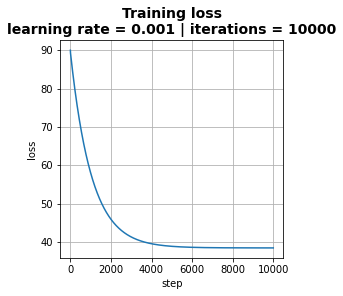

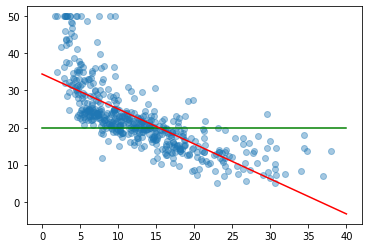

In [45]:
learning_rate = 1e-3
initial_w = np.array([[20], [0]])
print("Initial weight:\n", initial_w)
iterations = 10000

w, cost_history = batch_gradient_descent(X, y, initial_w, \
                                         learning_rate, iterations)

# Add into X a new column with 1s
Xe = np.append(np.ones([len(X),1]),X,1)

prediction = compute_prediction(Xe,w)

print("Final weight:\n", w)

r_2 = r_squared(y, prediction)
print("R squared = ", r_2)

simple_step_plot(
    [cost_history], 'loss',
    'Training loss\nlearning rate = {} | iterations = {}'.format(learning_rate, iterations))

plt.scatter(X[:,0], y, alpha=0.4)
x_reg = np.linspace(0, 40, 100)
y_reg = initial_w[1]*x_reg + initial_w[0]
plt.plot(x_reg, y_reg, c='g')
y_reg = w[1]*x_reg + w[0]
plt.plot(x_reg, y_reg, c='r')
plt.show()

## Exercise 3:
*Concisely* write here the experiments you have performed and any interesting comments you have based on the experiments (max 10 lines):

-



## Exercise 4: Comparison

- Use the normal equation code (analytical solution) of your EP2 to process the same dataset above.
- Print the final weight vector
- Compute the prediction using function <tt>compute_prediction()</tt> above
- compute and print the R-squared metric
- plot the line defined by the linear function $\mathbf{w}^T\mathbf{x}=0$ (where $\mathbf{w}$ is the final weight vector)
- add a text cell, and write any comments regarding what you have observed/learned by comparing the *batch gradient descent* and the analytical solution

In [29]:
def normal_equation_weights(X, y):
    """
    Calculates the weights of a linear function using the normal equation method.
    You should add into X a new column with 1s.

    :param X: design matrix
    :type X: np.ndarray(shape=(N, d))
    :param y: regression targets
    :type y: np.ndarray(shape=(N, 1))
    :return: weight vector
    :rtype: np.ndarray(shape=(d+1, 1))
    """
    
    # Add into X a new column with 1s
    X = np.append(np.ones([len(X),1]),X,1)
    
    # Calculates the weights using the normal equation method
    Xt = np.transpose(X)
    XtX = np.dot(Xt,X)
    XtX_inv = np.linalg.inv(XtX)
    XtY = np.dot(Xt,y)
    w = np.dot(XtX_inv,XtY)
    
    return w

X shape:  (506, 1)
y shape:  (506, 1)
Initial weight:
 [[20]
 [ 0]]
Final (analytical solution) weight:
 [[34.55384088]
 [-0.95004935]]
Final (batch gradient descent) weight:
 [[23.10640923]
 [-0.26277736]]
R squared (analytical solution) =  0.5441462975864799
R squared (batch gradient descent) =  0.1697158497476654


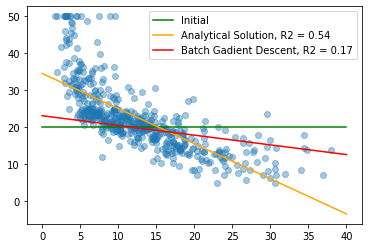

In [46]:
# Code to run and show resulst of the analytical solution
data = load_boston()
df = pd.DataFrame(data.data, columns=data.feature_names)

X = df.LSTAT.values.reshape((-1,1))
y = data.target.reshape((-1,1))
print("X shape: ", X.shape)
print("y shape: ", y.shape)

learning_rate = 0.001
initial_w = np.array([[20], [0]])
print("Initial weight:\n", initial_w)
iterations = 500

w_analy = normal_equation_weights(X, y)
w_batch, cost_history = batch_gradient_descent(X, y, initial_w, learning_rate, iterations)
print("Final (analytical solution) weight:\n", w_analy)
print("Final (batch gradient descent) weight:\n", w_batch)

# Add into X a new column with 1s
Xe = np.append(np.ones([len(X),1]),X,1)
    
prediction_analy = compute_prediction(Xe, w_analy)
prediction_batch = compute_prediction(Xe, w_batch)

r_2_analy = r_squared(y, prediction_analy)
r_2_batch = r_squared(y, prediction_batch)
print("R squared (analytical solution) = ", r_2_analy)
print("R squared (batch gradient descent) = ", r_2_batch)

plt.scatter(X[:,0], y, alpha=0.4)
x_reg = np.linspace(0, 40, 100)

y_reg = initial_w[1]*x_reg + initial_w[0]
plt.plot(x_reg, y_reg, c='g')
y_reg = w_analy[1]*x_reg + w_analy[0]
plt.plot(x_reg, y_reg, c='orange')
y_reg = w_batch[1]*x_reg + w_batch[0]
plt.plot(x_reg, y_reg, c='r')
plt.legend(["Initial", "Analytical Solution, R2 = {:.2f}".format(r_2_analy), "Batch Gadient Descent, R2 = {:.2f}".format(r_2_batch)], prop={"size":10})
plt.show()


The analytical solution shows not only the best model visually, but also as we can see in the legend, this method has better R2 value. This can be different depending on a distinct initial weight for the batch gradient descent.